In [14]:
import os
from docx import Document
import re
import spacy
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import pandas as pd
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Asus\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Asus\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [15]:
docs = []
path = "docs"
for dir in os.listdir(path):
    document = Document(os.path.join(path, dir))
    data = ''
    for para in document.paragraphs:
        data += " " + para.text
    docs.append(data)

In [16]:
class related_docs():

    def __init__(self, offset = 20):
        self.docs = []
        self.clean_docs = []
        self.labels = []
        self.size = 0
        self.best_k = 0
        self.nn = 3
        self.capacity = 0
        self.offset = offset
        self.vectorizer = TfidfVectorizer()
        self.knn = KNeighborsClassifier(n_neighbors=self.nn)
        self.nlp = spacy.load('en_core_web_sm', disable = ['parser', 'ner'])
        self.stop = stopwords.words('english')


    def text_cleaner(self, doc):
        doc = re.sub("[,.']", "", doc)
        doc = [token for token in doc.split(' ') if len(re.sub("[a-zA-Z]", "", token)) <= 0]
        doc = self.nlp(" ".join(doc))
        taglist = ['RB','RBR', 'RBS','JJR','JJ','JJS','NN','NNS','VB','VBG','VBP','VBN']
        poslist = ['ADJ','ADV','NOUN','VERB']
        doc = [token.lemma_.lower() for token in doc if token.tag_ in taglist and token.pos_ in poslist]
        doc = [token for token in doc if not token in self.stop and len(token)>2]
        return " ".join(doc)

    def clean_vectorize(self):
        self.clean_docs = []
        for doc in self.docs:
            self.clean_docs.append(self.text_cleaner(doc))
        
        self.doc_vect = self.vectorizer.fit_transform(self.clean_docs)

    def add(self, _docs):
        # clustering on all docs 
        if (len(_docs) + self.size) > self.capacity:
            self.docs.extend(_docs)
            self.clean_vectorize()
            self.size = len(self.docs)
            self.capacity = self.size + self.offset

            scores = []
            K = range(2, max(3, self.size//4)+1)
            for k in K:
                km = KMeans(n_clusters=k, max_iter=200, n_init=10)
                km = km.fit(self.doc_vect)
                labels = km.labels_
                score = silhouette_score(self.doc_vect, labels)
                scores.append((k, score))
            
            scores.sort(key = lambda x : x[1], reverse = True)
            self.best_k = scores[0][0]

            km = KMeans(n_clusters=self.best_k, max_iter=200, n_init=10)
            km = km.fit(self.doc_vect)
            self.labels = list(km.labels_)

            id_label = list(zip(range(1, self.size+1), self.labels))
            id_label.sort(key = lambda x : x[1])
            print(id_label)

            self.nn = int(self.size**0.5)
            self.nn = self.nn if self.nn%2 else self.nn%2-1
            self.knn = KNeighborsClassifier(n_neighbors=self.nn)
            self.knn.fit(self.doc_vect, self.labels)

        # knn on new docs
        else:
            _clean_docs = []
            for doc in _docs:
                _clean_docs.append(self.text_cleaner(doc))
            _doc_vect = self.vectorizer.transform(_clean_docs)
            _labels = self.knn.predict(_doc_vect)
            self.docs.extend(_docs)
            self.clean_docs.extend(_clean_docs)
            self.labels.extend(_labels)
            self.size += len(_docs)
            print(_labels)

    def find_clust(self, doc):
        clean_doc = self.text_cleaner(doc)
        _doc_vect = self.vectorizer.transform([clean_doc])
        _label = self.knn.predict(_doc_vect)

        return _label[0]

    def show_word_cloud(self):
        result={'cluster':self.labels,'data':self.clean_docs}
        result=pd.DataFrame(result)
        for k in range(0, self.best_k):
            s=result[result.cluster==k]
            text=s['data'].str.cat(sep=' ')
            text=text.lower()
            text=' '.join([word for word in text.split()])
            wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
            print('Cluster: {}'.format(k))
            plt.figure()
            plt.imshow(wordcloud, interpolation="bilinear")
            plt.axis("off")
            plt.show()

    def remove(self, pos):
        self.docs.pop(pos)
        self.clean_docs.pop(pos)
        self.labels.pop(pos)

    

[(2, 0), (3, 0), (4, 0), (5, 0), (1, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1)]
Cluster: 0


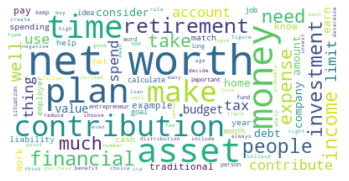

Cluster: 1


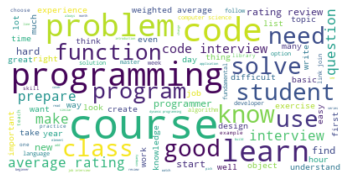

In [17]:
rld = related_docs(offset=40)
rld.add(docs[:10])
rld.show_word_cloud()

[0 1 0 1 1 1 1 0 1 1]
Cluster: 0


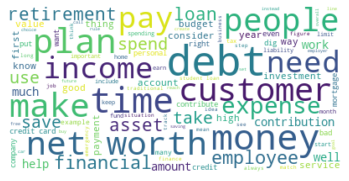

Cluster: 1


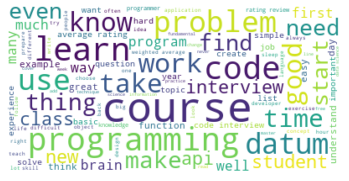

20

In [18]:
rld.add(docs[10:20])
rld.show_word_cloud()
len(rld.labels)